In [32]:
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import spacy
import re
import ast
import matplotlib.pyplot as plt
import pyLDAvis
import pyLDAvis.gensim_models 
import bertopic

from tqdm import tqdm

import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize

from gensim import corpora
from gensim.models import CoherenceModel,LdaModel,LsiModel
from sklearn.metrics import silhouette_samples, silhouette_score

from itertools import chain

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.model_selection import GridSearchCV
from gensim.models.callbacks import CallbackAny2Vec
from gensim.models import Word2Vec, Phrases, KeyedVectors
from gensim.models.phrases import Phraser
from gensim.utils import simple_preprocess
from nltk.corpus import wordnet
# from pattern.en import pluralize, singularize
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# DATA EXPLORATION & PREPROCESSING


In [33]:
# data loading
dataset = pd.read_json("News_Category_Dataset_v2.json", lines=True, dtype={"headline": str})
dataset.head()

,category,headline,authors,link,short_description,date
0,CRIME,There Were 2 Mass Shootings In Texas Last Week...,Melissa Jeltsen,https://www.huffingtonpost.com/entry/texas-ama...,She left her husband. He killed their children...,2018-05-26
1,ENTERTAINMENT,Will Smith Joins Diplo And Nicky Jam For The 2...,Andy McDonald,https://www.huffingtonpost.com/entry/will-smit...,Of course it has a song.,2018-05-26
2,ENTERTAINMENT,Hugh Grant Marries For The First Time At Age 57,Ron Dicker,https://www.huffingtonpost.com/entry/hugh-gran...,The actor and his longtime girlfriend Anna Ebe...,2018-05-26
3,ENTERTAINMENT,Jim Carrey Blasts 'Castrato' Adam Schiff And D...,Ron Dicker,https://www.huffingtonpost.com/entry/jim-carre...,The actor gives Dems an ass-kicking for not fi...,2018-05-26
4,ENTERTAINMENT,Julianna Margulies Uses Donald Trump Poop Bags...,Ron Dicker,https://www.huffingtonpost.com/entry/julianna-...,"The ""Dietland"" actress said using the bags is ...",2018-05-26


In [34]:
def dummy_word_split(texts):
    """Function identifying words in a sentence in a really dummy way.

        Argument:
            - texts (list of str): a list of raw texts in which we'd like to identify words

        Return:
            - list of list containing each word separately.
    """
    texts_out = []
    for text in texts:
        texts_out.append(text.split(" "))

    return texts_out

In [35]:
def compute_word_occurences(texts):
    """You have to define this function yourself. """

    words = itertools.chain.from_iterable(texts)

    word_count = pd.Series(words).value_counts()
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values})

    return word_count

In [36]:
splitted_texts = dummy_word_split(dataset["headline"].tolist())
compute_word_occurences(splitted_texts).head(20)

,Word,Count
0,The,47803
1,To,38569
2,A,24839
3,In,24141
4,Of,22956
5,For,18788
6,Is,16823
7,And,15137
8,On,13642
9,With,12556


La plupart des mots fréquents semblent être des stopwords courants, tels que "the," "to," "a," "in," etc. Ces mots n'apportent généralement pas beaucoup de sens individuellement et peuvent être éliminés lors du preprocessing.

Des variations de cas (majuscules et minuscules) pour des mots comme "The" et "the." La normalisation en minuscules peut être utile pour traiter ces variations.

In [37]:
def check_data_quality(texts):
    """Check wheter all the dataset is conform to the expected behaviour."""
    assert all([isinstance(t, str) for t in texts]), "Input data contains something different than strings."
    assert all([t != np.nan for t in texts]), "Input data contains NaN values."

    return True

In [38]:
def force_format(texts):
    return [str(t) for t in texts]

In [39]:
texts = force_format(dataset["headline"])
print(f"Is the dataset passing our data quality check?\n{check_data_quality(texts)}")

Is the dataset passing our data quality check?
True


In [40]:
texts[:5]

['There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song",
 'Hugh Grant Marries For The First Time At Age 57',
 "Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork",
 'Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog']

In [41]:
def filter_text(texts_in):
    """Removes incorrect patterns from a list of texts, such as hyperlinks, bullet points and so on"""

    texts_out = re.sub(r'https?:\/\/[A-Za-z0-9_.-~\-]*', ' ', texts_in, flags=re.MULTILINE)
    texts_out = re.sub(r'[(){}\[\]<>]', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&amp;#.*;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&gt;', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'â€™', "'", texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'\s+', ' ', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'&#x200B;', ' ', texts_out, flags=re.MULTILINE)
    # Mail regex
    # This regex is correct but WAY TOO LONG to process. So we skip it with a simpler version
    # texts_out = re.sub(r"(?i)(?:[a-z0-9!#$%&'*+\/=?^_`{|}~-]+(?:\.[a-z0-9!#$%&'*+\/=?^_`{|}~-]+)*|\"(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21\x23-\x5b\x5d-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])*\")@(?:(?:[a-z0-9](?:[a-z0-9-]*[a-z0-9])?\.)+[a-z0-9](?:[a-z0-9-]*[a-z0-9])?|\[(?:(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9]))\.){3}(?:(2(5[0-5]|[0-4][0-9])|1[0-9][0-9]|[1-9]?[0-9])|[a-z0-9-]*[a-z0-9]:(?:[\x01-\x08\x0b\x0c\x0e-\x1f\x21-\x5a\x53-\x7f]|\\[\x01-\x09\x0b\x0c\x0e-\x7f])+)\])", '', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r'[a-zA-Z0-9-_.]+@[a-zA-Z0-9-_.]+\.[a-zA-Z0-9-_.]+', '', texts_out, flags=re.MULTILINE)
    # Phone regex
    # This regex is correct but WAY TOO LONG to process. So we skip it with a simpler version
    # texts_out = re.sub(r".*?(\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}).*?", '', texts_out, flags=re.MULTILINE)
    texts_out = re.sub(r"\(?\d{3}\D{0,3}\d{3}\D{0,3}\d{4}", '', texts_out, flags=re.MULTILINE)
    # Remove names in twitter
    texts_out = re.sub(r'@\S+( |\n)', '', texts_out, flags=re.MULTILINE)

    # Remove starts commonly used on social media
    texts_out = re.sub(r'\*', '', texts_out, flags=re.MULTILINE)
    return texts_out


In [42]:
texts = [filter_text(t) for t in texts]
texts[:5]

['There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV',
 "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song",
 'Hugh Grant Marries For The First Time At Age 57',
 "Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork",
 'Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog']

In [43]:
def sent_to_words(sentences):
    """Converts sentences to words.

    Convert sentences in lists of words while removing the accents and the punctuation.

    @param:
        sentences: a list of strings, the sentences we want to convert
    @return
        A list of words' lists.
    """
    for sentence in tqdm(sentences):
        yield (simple_preprocess(str(sentence), deacc=True))


In [44]:
texts = list(sent_to_words(texts))
texts[:2]

100%|██████████| 200853/200853 [00:06<00:00, 32247.28it/s]


[['there',
  'were',
  'mass',
  'shootings',
  'in',
  'texas',
  'last',
  'week',
  'but',
  'only',
  'on',
  'tv'],
 ['will',
  'smith',
  'joins',
  'diplo',
  'and',
  'nicky',
  'jam',
  'for',
  'the',
  'world',
  'cup',
  'official',
  'song']]

In [45]:
def get_stopwords(additional_stopwords=[]):
    """Return a list of english stopwords, that can be augmented by using a stopwords file or a list of stopwords

    Args:
        filepath (str, optional): path to a text file where each line is a stopword
        additional_stopwords (list of str, optional): list of string representing stopwords
    Returns:
        List of strings representing stopwords
    """
    # Loading standard english stop words
    with open('stopwords.txt', 'r') as f:
        stop_w = f.readlines()
    stopwords = [s.rstrip() for s in stop_w]

    # Adding stop words from sklearn
    stopwords = list(text.ENGLISH_STOP_WORDS.union(stopwords))

    # Adding words from a list if specified
    if additional_stopwords:
        stopwords += additional_stopwords

    # Removing duplicates
    stopwords = list(set(stopwords))

    # Removing some \n that were included in the native stopwords of sklearn ... WHY?
    stopwords = [s.replace("\n", "") for s in stopwords]

    stopwords = sorted(stopwords, key=str.lower)

    return stopwords


In [46]:
stopwords = get_stopwords(additional_stopwords=["trump"])

texts = [[word for word in txt if word not in stopwords] for txt in tqdm(texts)]

  1%|          | 1011/200853 [00:00<00:19, 10086.95it/s]

100%|██████████| 200853/200853 [00:13<00:00, 14506.94it/s]


In [47]:
texts[:5]

[['mass', 'shootings', 'texas', 'week', 'tv'],
 ['smith',
  'joins',
  'diplo',
  'nicky',
  'jam',
  'world',
  'cup',
  'official',
  'song'],
 ['hugh', 'grant', 'marries', 'time', 'age'],
 ['jim',
  'carrey',
  'blasts',
  'castrato',
  'adam',
  'schiff',
  'democrats',
  'artwork'],
 ['julianna', 'margulies', 'donald', 'poop', 'bags', 'pick', 'dog']]

In [48]:
def create_bigrams(texts, bigram_count=15, threshold=10, convert_sent_to_words=False, as_str=True):
    """Identify bigrams in texts and return the texts with bigrams integrated"""
    if convert_sent_to_words:
        texts = list(sent_to_words(texts))

    bigram_model = Phraser(Phrases(texts, min_count=bigram_count, threshold=threshold))

    if as_str:
        return [" ".join(bigram_model[t]) for t in texts]

    else:
        return [bigram_model[t] for t in texts]

In [49]:
texts = create_bigrams(texts)
texts[:5]

['mass_shootings texas week tv',
 'smith joins diplo nicky jam world_cup official song',
 'hugh grant marries time age',
 'jim_carrey blasts castrato adam schiff democrats artwork',
 'julianna margulies donald poop bags pick dog']

In [50]:
! python -m spacy download en_core_web_md

     ---------------------------------------- 0.0/42.8 MB ? eta -:--:--
     --------------------------------------- 0.0/42.8 MB 660.6 kB/s eta 0:01:05
     ---------------------------------------- 0.2/42.8 MB 2.5 MB/s eta 0:00:18
     ---------------------------------------- 0.5/42.8 MB 4.0 MB/s eta 0:00:11
      --------------------------------------- 0.8/42.8 MB 4.6 MB/s eta 0:00:10
     - -------------------------------------- 1.1/42.8 MB 4.9 MB/s eta 0:00:09
     - -------------------------------------- 1.4/42.8 MB 5.2 MB/s eta 0:00:08
     - -------------------------------------- 1.7/42.8 MB 5.4 MB/s eta 0:00:08
     - -------------------------------------- 2.0/42.8 MB 5.6 MB/s eta 0:00:08
     -- ------------------------------------- 2.3/42.8 MB 5.6 MB/s eta 0:00:08
     -- ------------------------------------- 2.6/42.8 MB 5.7 MB/s eta 0:00:08
     -- ------------------------------------- 2.9/42.8 MB 5.8 MB/s eta 0:00:07
     -- ------------------------------------- 3.2/42.8 MB 

In [51]:
def lemmatize_texts(texts,
                    allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'],
                    forbidden_postags=[],
                    as_sentence=False,
                    get_postags=False,
                    spacy_model=None):
    POS_map = {
        'NOUN': 'noun',
        'ADJ': 'adjective',
        'VERB': 'verb',
        'ADV': 'adverb'
    }
    """Lemmatize a list of texts.

            Please refer to https://spacy.io/api/annotation for details on the allowed
        POS tags.
        @params:
            - texts_in: a list of texts, where each texts is a string
            - allowed_postags: a list of part of speech tags, in the spacy fashion
            - as_sentence: a boolean indicating whether the output should be a list of sentences instead of a list of word lists
        @return:
            - A list of texts where each entry is a list of words list or a list of sentences
        """
    texts_out = []

    if allowed_postags and forbidden_postags:
        raise ValueError("Can't specify both allowed and forbidden postags")

    if forbidden_postags:
        allowed_postags = list(set(POS_map.keys()).difference(set(forbidden_postags)))

    if not spacy_model:
        print("Loading spacy model")
        spacy_model = spacy.load('en_core_web_md')

    print("Beginning lemmatization process")
    total_steps = len(texts)

    docs = spacy_model.pipe(texts)

    for i, doc in tqdm(enumerate(docs), total=total_steps):
        if get_postags:
            texts_out.append(["_".join([token.lemma_, token.pos_]) for token in doc if token.pos_ in allowed_postags])
        else:
            texts_out.append(
                [token.lemma_ for token in   doc if token.pos_ in allowed_postags])

    if as_sentence:
        texts_out = [" ".join(text) for text in texts_out]

    return texts_out


In [52]:
l_texts = lemmatize_texts(texts,
                allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV', 'X', 'PROPN'],
                get_postags=False)

Loading spacy model


c:\Users\Daito\miniconda3\envs\NLP\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\Daito\miniconda3\envs\NLP\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\Daito\miniconda3\envs\NLP\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\Daito\miniconda3\envs\NLP\Lib\site-packages\catalogue\__init__.py:135: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
c:\Users\Daito\miniconda3\envs\NLP\Lib\s

Beginning lemmatization process


100%|██████████| 200853/200853 [03:40<00:00, 912.32it/s] 


In [53]:
occurences = compute_word_occurences(l_texts)
occurences.head()

,Word,Count
0,photo,11806
1,video,5716
2,make,4887
3,woman,4542
4,donald,4475


In [54]:
dataset['category'].nunique()

41


On a 41 catégorie différentes dans notre dataset.


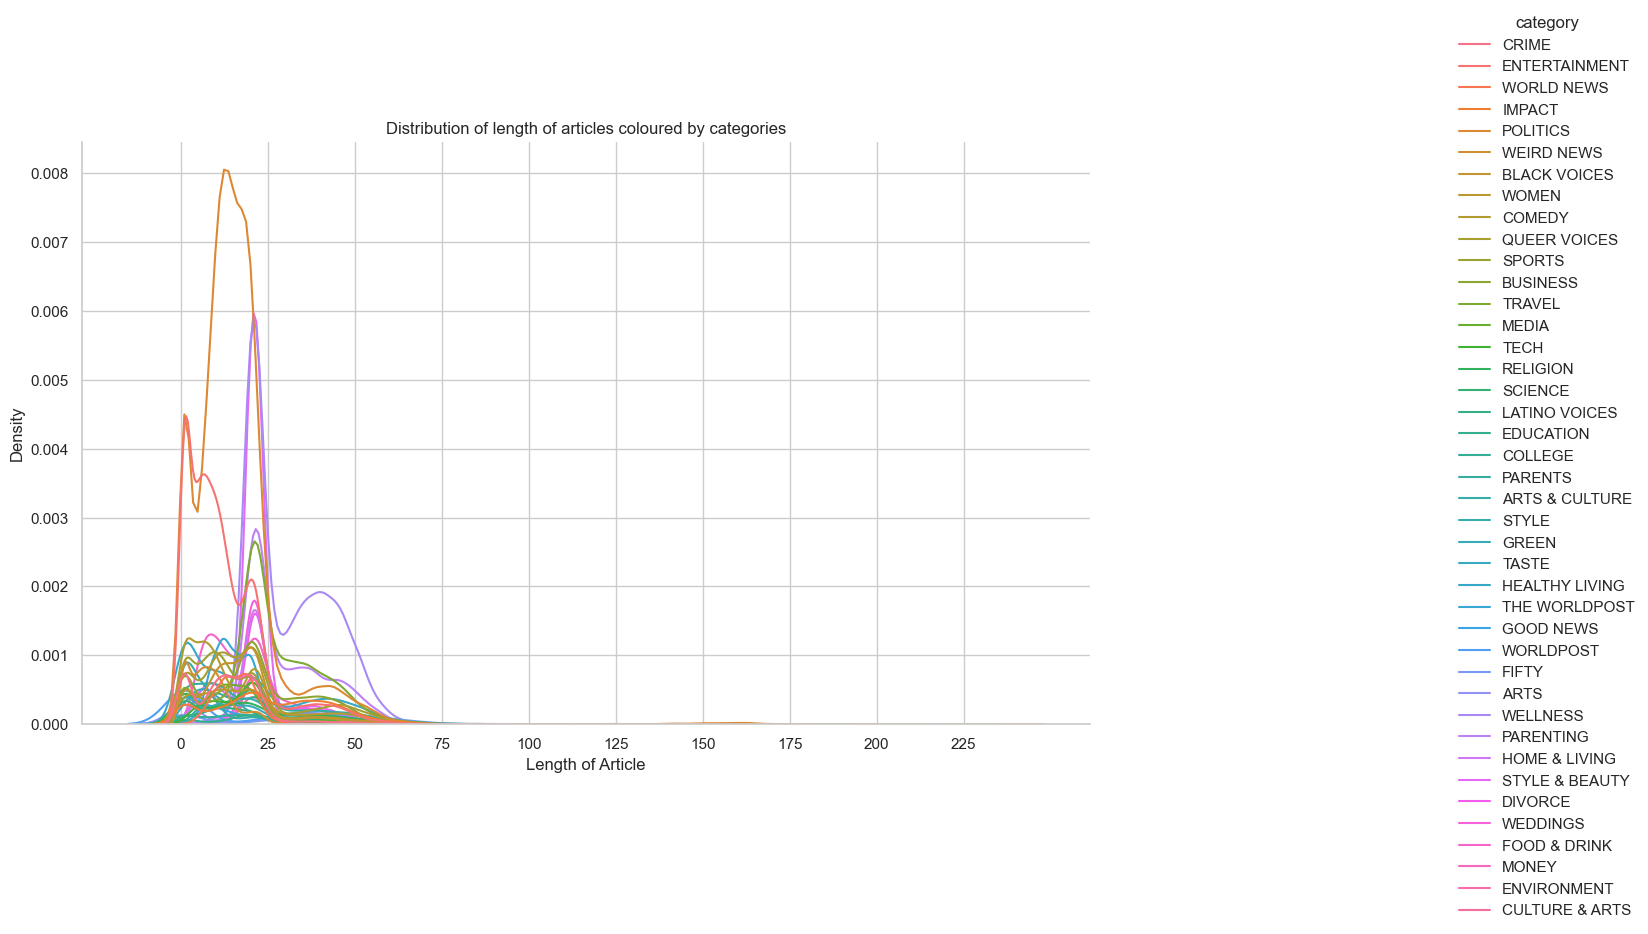

In [55]:
sns.set(style = 'whitegrid')
figu = sns.displot(x = dataset['short_description'].str.split(' ').apply(len), hue = dataset['category'], kind = 'kde')
figu.figure.set_size_inches(18,7)
figu.set(title = f'Distribution of length of articles coloured by categories', xlabel = 'Length of Article', xticks = range(0,250,25))
plt.show()

In [56]:
# Download the NLTK resources (run this once)
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Daito\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Daito\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [57]:
text = ' '.join(dataset['headline'])  # Combine all headlines into one string

# Tokenize the text and get part-of-speech tags
tokens = word_tokenize(text)
pos_tags = pos_tag(tokens)

# Filter words based on their part-of-speech tags
nouns = [word for word, pos in pos_tags if pos.startswith('N')]
verbs = [word for word, pos in pos_tags if pos.startswith('V')]
adjectives = [word for word, pos in pos_tags if pos.startswith('J')]

# Display the most common words for each category
common_nouns = pd.Series(nouns).value_counts().head(10)
common_verbs = pd.Series(verbs).value_counts().head(10)
common_adjectives = pd.Series(adjectives).value_counts().head(10)

print("Top 10 Most Common Nouns:")
print(common_nouns)

print("\nTop 10 Most Common Verbs:")
print(common_verbs)

print("\nTop 10 Most Common Adjectives:")
print(common_adjectives)


Top 10 Most Common Nouns:
A         17458
Trump     12533
PHOTOS     9039
New        8462
How        6486
Donald     4586
’          4515
Day        4391
Is         4210
VIDEO      4142
Name: count, dtype: int64

Top 10 Most Common Verbs:
Is      13415
's       5876
Do       4037
Are      4010
Be       3730
Have     2731
s        1842
Make     1740
Get      1693
Need     1564
Name: count, dtype: int64

Top 10 Most Common Adjectives:
More        2930
Best        1125
Other       1092
Most        1026
Last         785
American     725
Good         695
Own          531
Much         502
Next         462
Name: count, dtype: int64


## Chargement des données 

In [2]:
def force_format(texts):
    return [str(t) for t in texts]

def compute_word_occurences(texts):
    words = itertools.chain.from_iterable(texts)
    word_count = pd.Series(words).value_counts()
    word_count = pd.DataFrame({"Word": word_count.index, "Count": word_count.values})
    return word_count

def get_l_texts(text_file): #text_file is a .txt file from preprocessing to avoid doing it again
    l_texts=[]
    with open(text_file, "r") as f:
        line = f.readlines()
        list_line = [l.strip() for l in line]
        for l in list_line:
            l_texts.append(ast.literal_eval(l))
    return l_texts

In [3]:
dataset = pd.read_json("News_Category_Dataset_v2.json", lines=True, dtype={"headline": str})
texts = force_format(dataset["headline"])
l_texts = get_l_texts("l_texts.txt")
print(l_texts[:10],"\n",texts[:10],"\n",dataset["headline"][:10])

[['mass_shooting', 'texas', 'week', 'tv'], ['smith', 'join', 'diplo', 'nicky', 'jam', 'world_cup', 'official', 'song'], ['hugh', 'grant', 'marries', 'time', 'age'], ['jim_carrey', 'blasts', 'castrato', 'adam', 'schiff', 'democrats', 'artwork'], ['julianna', 'margulie', 'donald', 'poop', 'bag', 'pick', 'dog'], ['morgan_freeman', 'devastate', 'sexual_harassment', 'claim', 'undermine', 'legacy'], ['donald', 'lovin', 'mcdonald', 'jingle', 'tonight', 'bit'], ['watch', 'amazon', 'prime', 'week'], ['mike', 'myers', 'reveal', 'fourth', 'austin', 'power', 'film'], ['watch', 'hulu', 'week']] 
 ['There Were 2 Mass Shootings In Texas Last Week, But Only 1 On TV', "Will Smith Joins Diplo And Nicky Jam For The 2018 World Cup's Official Song", 'Hugh Grant Marries For The First Time At Age 57', "Jim Carrey Blasts 'Castrato' Adam Schiff And Democrats In New Artwork", 'Julianna Margulies Uses Donald Trump Poop Bags To Pick Up After Her Dog', "Morgan Freeman 'Devastated' That Sexual Harassment Claims Cou

In [4]:
# Create a dictionary
dictionary = corpora.Dictionary(l_texts)
# Create a corpus
corpus = [dictionary.doc2bow(text) for text in l_texts]

print("Number of unique tokens: {}".format(len(dictionary)))
print("Number of documents: {}".format(len(corpus)))

Number of unique tokens: 47649
Number of documents: 200853


## Pour les modèles disponibles dans la librairie gensim

### LDA

In [5]:
result={"num_topics":[], "coherence_score_cv":[],"coherence_score_npmi":[]}

for n in range(50, 65):
    lda_model = LdaModel(corpus, num_topics=n, id2word=dictionary)
    coherence_model_cv= CoherenceModel(model=lda_model, texts=l_texts, dictionary=dictionary, coherence='c_v')
    coherence_score_cv = coherence_model_cv.get_coherence()
    coherence_model_npmi= CoherenceModel(model=lda_model, texts=l_texts, dictionary=dictionary, coherence='c_npmi')
    coherence_score_npmi = coherence_model_npmi.get_coherence()
    print("Number of topics: ", n, " Coherence Score: ", coherence_score_npmi,coherence_score_cv)
    result["num_topics"].append(n)
    result["coherence_score_cv"].append(coherence_score_cv)
    result["coherence_score_npmi"].append(coherence_score_npmi)

Number of topics:  50  Coherence Score:  -0.2824209588809716 0.5098044333816348
Number of topics:  51  Coherence Score:  -0.28828241735395443 0.5181689460125675
Number of topics:  52  Coherence Score:  -0.2874787327215478 0.5153331178821003
Number of topics:  53  Coherence Score:  -0.2943429399351826 0.5255018014061624
Number of topics:  54  Coherence Score:  -0.29591946141787323 0.5268862888920597
Number of topics:  55  Coherence Score:  -0.2960636395784447 0.5284503792971005
Number of topics:  56  Coherence Score:  -0.3000395592161475 0.5323435274476381
Number of topics:  57  Coherence Score:  -0.29919743955948835 0.5319902171309276
Number of topics:  58  Coherence Score:  -0.2971918680648036 0.5283476888252082
Number of topics:  59  Coherence Score:  -0.29820176195152787 0.5307283765564802
Number of topics:  60  Coherence Score:  -0.30102524437381867 0.5353576336774502
Number of topics:  61  Coherence Score:  -0.2973235104383298 0.5288722685081988
Number of topics:  62  Coherence Sc

In [6]:
optimal_n=result["num_topics"][np.argmax(result["coherence_score_cv"])]
lda_model = LdaModel(corpus, num_topics=n, id2word=dictionary)
coherence_model_cv= CoherenceModel(model=lda_model, texts=l_texts, dictionary=dictionary, coherence='c_v')
coherence_score_cv = coherence_model_cv.get_coherence()
coherence_model_npmi= CoherenceModel(model=lda_model, texts=l_texts, dictionary=dictionary, coherence='c_npmi')
coherence_score_npmi = coherence_model_npmi.get_coherence()
print("Optimal number of topics: ", optimal_n, " Coherence Score: ", coherence_score_npmi,coherence_score_cv)

Optimal number of topics:  60  Coherence Score:  -0.2963964682921284 0.5238451755756386


In [7]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
40     0.273228 -0.393936       1        1  3.120898
7      0.121276  0.060614       2        1  2.526671
36     0.114935  0.054518       3        1  2.422017
51     0.184520  0.204718       4        1  2.264360
12     0.086480  0.032894       5        1  2.118721
...         ...       ...     ...      ...       ...
2     -0.064822 -0.012017      60        1  1.162177
26    -0.089962 -0.014965      61        1  1.104601
21    -0.097759 -0.015726      62        1  1.090094
57    -0.035732 -0.007576      63        1  1.069262
0     -0.075777 -0.013380      64        1  1.026531

[64 rows x 5 columns], topic_info=           Term          Freq         Total Category  logprob  loglift
204       photo  27454.000000  27454.000000  Default  30.0000  30.0000
305       video  14917.000000  14917.000000  Default  29.0000  29.0000
294        make   8629.000000   8629.000000  Default  28.0000  28.0000
496         day   7678.000000   7678.000000  Default  27.0000  27.0000
1550    divorce   5602.000000   5602.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
768       cameo     70.262442     72.252034  Topic64  -5.0411   4.5511
4499      loser     61.461771     63.451358  Topic64  -5.1749   4.5471
4500        nyt     53.305953     55.295540  Topic64  -5.3172   4.5423
1192  boy_scout     48.253104     50.242692  Topic64  -5.4168   4.5386
444    interest     42.194139     44.183726  Topic64  -5.5510   4.5329

[1952 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
1144     28  0.988144    aaron
1163     38  0.995406  abandon
3195     56  0.983082      abc
4347     13  0.983172  ability
601      54  0.990211   abroad
...     ...       ...      ...
623      52  0.998602     york
1063     15  0.998599    young
1236     29  0.990522    youth
1122     32  0.984424   zombie
2767      4  0.973939      zoo

[1919 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[41, 8, 37, 52, 13, 44, 16, 64, 62, 18, 15, 17, 7, 26, 6, 54, 56, 39, 2, 55, 61, 14, 50, 59, 57, 42, 60, 63, 34, 24, 4, 43, 5, 35, 38, 20, 49, 28, 23, 31, 10, 9, 11, 40, 19, 12, 30, 53, 51, 45, 33, 47, 29, 48, 25, 36, 46, 32, 21, 3, 27, 22, 58, 1])

### LSI


In [8]:
lsi_model = LsiModel(corpus, num_topics=optimal_n, id2word=dictionary)
coherence_model_cv= CoherenceModel(model=lsi_model, texts=l_texts, dictionary=dictionary, coherence='c_v')
coherence_score_cv = coherence_model_cv.get_coherence()
coherence_model_npmi= CoherenceModel(model=lsi_model, texts=l_texts, dictionary=dictionary, coherence='c_npmi')
coherence_score_npmi = coherence_model_npmi.get_coherence()
print("Number of topics: ", optimal_n, " Coherence Score: ", coherence_score_npmi,coherence_score_cv)

c:\Users\Daito\miniconda3\envs\NLP\Lib\site-packages\gensim\models\lsimodel.py:963: DeprecationWarning: Please use `csc_matvecs` from the `scipy.sparse` namespace, the `scipy.sparse.sparsetools` namespace is deprecated.
  sparsetools.csc_matvecs(
c:\Users\Daito\miniconda3\envs\NLP\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\Daito\miniconda3\envs\NLP\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprecated as of SciPy 1.11.0 and will be removed in v1.13.0. Please use numpy.(tri/tril/triu) instead.
  out = (1 - tri(m.shape[0], m.shape[1], k - 1, m.dtype.char)) * m
c:\Users\Daito\miniconda3\envs\NLP\Lib\site-packages\scipy\linalg\_special_matrices.py:154: DeprecationWarning: 'tri'/'tril/'triu' are deprec

Number of topics:  60  Coherence Score:  -0.0426014760788819 0.23731591431451662


In [ ]:
# Visualize the topics
#Not possible with LSI

## BERTOPIC

In [ ]:
representation=bertopic.representation.KeyBERTInspired()
model_trained_representation= bertopic.BERTopic(representation_model=representation,nr_topics=optimal_n)
topics,probs = model_trained_representation.fit_transform(dataset['headline'])

In [ ]:
dictionary = corpora.Dictionary(l_texts)
coherence_model= CoherenceModel(model=model_trained_representation, texts=l_texts, dictionary=dictionary, coherence='c_v')
coherence_score_cv = coherence_model.get_coherence()
coherence_model= CoherenceModel(model=model_trained_representation, texts=l_texts, dictionary=dictionary, coherence='c_npmi')
coherence_score_c_npmi = coherence_model.get_coherence()
print("Coherence Score: ", coherence_score_cv,coherence_score_c_npmi)

In [9]:
model_trained_representation.visualize_topics()

In [20]:
(model_trained_representation.get_topic_info())

,Topic,Count,Name,Representation,Representative_Docs
0,-1,82942,-1_life_mom_love_wedding,"[life, mom, love, wedding, house, donald, day,...",[John Legend Says It Would Take A Gun To His H...
1,0,18986,0_fashion_dress_style_makeup,"[fashion, dress, style, makeup, miley, beauty,...",[Lena Dunham's McQ Dress On 'Girls' Shows Hann...
2,1,15829,1_trump_colbert_donald_trumps,"[trump, colbert, donald, trumps, bernie, presi...",[Seth Meyers Calls Out Donald Trump Jr. As The...
3,2,7611,2_foods_healthy_food_diet,"[foods, healthy, food, diet, nutrition, eating...","[Fast Food the Healthy Way: A Guide, Healthy F..."
4,3,6092,3_meditation_meditations_meditate_mindfulness,"[meditation, meditations, meditate, mindfulnes...","[Meditation Tips for the Day 1, How We Can Hel..."
5,4,4945,4_police_cops_officers_officer,"[police, cops, officers, officer, cop, violenc...",[Florida Cops On What Ferguson Can Learn From ...
6,5,4707,5_isis_syria_syrias_yemen,"[isis, syria, syrias, yemen, syrian, iran, isr...",[Israel Has Lost the War Against Hamas in Gaza...
7,6,4659,6_parenting_mothers_tweets_twitter,"[parenting, mothers, tweets, twitter, parental...",[Best Parenting Tweets: What Moms And Dads Sai...
8,7,4527,7_trumpcare_obamacare_health_medicaid,"[trumpcare, obamacare, health, medicaid, medic...",[Republicans Could Actually Pass This Health C...
9,8,3858,8_destinations_vacation_travelers_travel,"[destinations, vacation, travelers, travel, tr...","[Best New Travel Gadgets for 2014 (PHOTOS), 7 ..."
